In [1]:
#Importing all required libraries
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as  tf


In [2]:
#As the original paper on Neural Style Transfer uses previously trained convolutional network
#Here we are loading VGG-19 layer of VGG network.
#Note: this model has already been trained on Imagenet
model = load_vgg_model('pretrained-model/imagenet-vgg-verydeep-19.mat') #from nst_utils.py
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shap

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


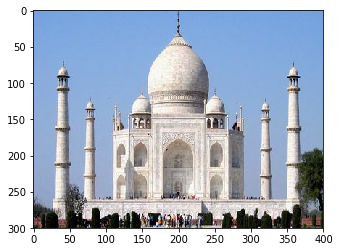

In [3]:
#Loading content image
content_image = scipy.misc.imread('images/taj_mahal.jpg')
imshow(content_image)

In [4]:
# Computing Content cost
def compute_content_cost(a_C, a_G):
    #Retreving dimensions of Generated image
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    #Reshape a_C and a_G into 2D
    a_C_unrolled = tf.transpose(tf.reshape(a_C,[n_H * n_W, n_C]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G,[n_H * n_W, n_C]))
    
    #Computing cost
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))/ (4*n_H*n_W*n_C)
    
    return J_content
    

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


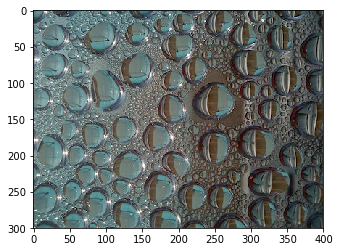

In [5]:
# Loading style image
style_image = scipy.misc.imread('images/drop-of-water.jpg')
imshow(style_image)

In [6]:
#To compute style cost, we need to find gram matrix / style matrix. 
#The gram matrix is used to find the correlation between the filters
#Computing gram matrix of A
def gram_matrix(A):
    
    '''GA represents gram matrix of A'''
    GA = tf.matmul(A, tf.transpose(A))
    return GA

In [7]:
#Style cost for single layer
def compute_single_layer_style_cost(a_S, a_G):
    
    #Retrieve the dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    #Reshape a_C and a_G into 2D
    a_G_unrolled = tf.transpose(tf.reshape(a_G,[n_H * n_W, n_C]))
    a_S_unrolled = tf.transpose(tf.reshape(a_S,[n_H * n_W, n_C]))
    
    #Computing Gram matrices for both images G and S
    GS = gram_matrix(a_S_unrolled)
    GG = gram_matrix(a_G_unrolled)
    
    #Computing style loss
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS, GG)))/ (4*(n_H*n_W*n_C)**2)
    
    return J_style_layer

So far we have captured style cost for single layer. To get better results, we plan to compute style cost across different layers and merge them togther. Choice of layers for computing style cost is empirical

In [8]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)
]

In [9]:
#Computing overall style cost
def compute_style_cost(model, STYLE_LAYERS):
    
    #Initialising overall style cost
    J_style = 0
    for layer_name, coeff in STYLE_LAYERS:
        
        #Selecting the output tensor of currently selected layer
        out = model[layer_name]
        
        #Select a_S to be the hidden activation from the layer we have selected, by running session on out
        a_S = sess.run(out)
        
        #Also we are specifying a_G to be hidden layer activation from the same layer.
        a_G = out
        
        #Computing style cost for the current layer
        J_style_layer = compute_single_layer_style_cost(a_S, a_G)
        
        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer
        
    return J_style

Total cost = alpha * J_content + beta * J_style

In [10]:
#Computing total cost
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha * J_content + beta * J_style
    
    return J


# Optimising neural style transfer


In [11]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [12]:
#Loading, reshaping and normalizing content image
content_image = scipy.misc.imread("images/taj_mahal.jpg")
content_image = reshape_and_normalize_image(content_image)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


In [13]:
#Loading, reshaping and normalizing style image
style_image = scipy.misc.imread("images/drop-of-water.jpg")
style_image = reshape_and_normalize_image(style_image)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


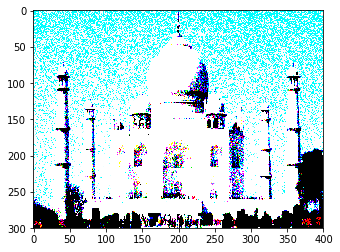

In [14]:
#Now we are going to initialize  generated image as noisy image created from the content image.
#This way it will help the generated image to more rapidly match the content of the content image

generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [15]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [16]:
#Assign the content image to input of VGG model
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from the same layer.
a_G = out

J_content = compute_content_cost(a_C, a_G)

In [17]:
#Assigning style image to the input of the model
sess.run(model['input'].assign(style_image))

#Computing style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [18]:
#Overall cost
J = total_cost(J_content, J_style, alpha = 10, beta = 40)

In [19]:
#Using Adam Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = 2.0)

#Minimizing J
train_step = optimizer.minimize(J)

In [20]:
#Iterating the model
def model_nn(sess, input_image, num_iterations = 200):
    
    #Initializing global variables
    sess.run(tf.global_variables_initializer())
    
    #Run noisy input images through the model
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
        _ = sess.run(train_step)
        
        generated_image = sess.run(model['input'])
        
        if i % 20 == 0:
            J_t, J_c, J_s = sess.run([J, J_content, J_style])
            print('Iteration '+str(i)+":")
            print('total cost = '+str(J_t))
            print('content cost = '+str(J_c))
            print('style cost = '+str(J_s))
            
            
            #saving the image to output directory
            save_image('output/'+str(i)+".png",generated_image)
    
    #save last generated image
    save_image('output/generated_image.jpg',generated_image)
    
    return generated_image
        
        

In [21]:
model_nn(sess, generated_image)

Iteration 0:
total cost = 1899818000.0
content cost = 12293.661
style cost = 47492376.0
Iteration 20:
total cost = 156600770.0
content cost = 19573.994
style cost = 3910125.5
Iteration 40:
total cost = 67731944.0
content cost = 22111.229
style cost = 1687770.8
Iteration 60:
total cost = 43164940.0
content cost = 22905.44
style cost = 1073397.1
Iteration 80:
total cost = 32762220.0
content cost = 23428.71
style cost = 813198.3
Iteration 100:
total cost = 26810436.0
content cost = 23813.412
style cost = 664307.56
Iteration 120:
total cost = 22873948.0
content cost = 24119.861
style cost = 565818.75
Iteration 140:
total cost = 20042798.0
content cost = 24367.236
style cost = 494978.16
Iteration 160:
total cost = 17873236.0
content cost = 24566.984
style cost = 440689.16
Iteration 180:
total cost = 16135009.0
content cost = 24736.496
style cost = 397191.1


array([[[[  16.811491 ,  -37.868736 ,   -5.875324 ],
         [  28.663307 ,    3.7635355,   13.582301 ],
         [  30.45036  ,   33.54422  ,   50.609013 ],
         ...,
         [  36.778534 ,   24.270098 ,   75.86249  ],
         [  45.152756 ,   62.06557  ,   86.62021  ],
         [  50.876194 ,   55.22847  ,   76.061134 ]],

        [[  24.464808 ,    9.737905 ,   18.130026 ],
         [  15.151524 ,   19.998472 ,   36.05621  ],
         [  30.368649 ,   46.87175  ,   64.97295  ],
         ...,
         [ -64.237595 ,  -41.80167  ,   -8.119445 ],
         [  34.960873 ,   16.523417 ,   20.434177 ],
         [  38.418583 ,   25.76057  ,   45.588474 ]],

        [[  22.50485  ,   14.559147 ,   25.259106 ],
         [  11.726544 ,   -7.268752 ,   14.395826 ],
         [  32.742336 ,    5.6197953,  -10.527764 ],
         ...,
         [ -44.765736 ,  -30.58106  ,    7.186483 ],
         [ -17.234978 ,  -15.4959   ,   22.407621 ],
         [ -17.770588 ,   -9.761336 ,   22.042833 ]],